In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:
zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm,num_eigen=11,init_vector=None,num_Lanczos=None,iteration=None,tolerance=0)

In [6]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM02/spencer/daily_filt/filtered_vels.zarr')
#vels_unfiltered2 = xr.open_zarr('/swot/SUM02/spencer/daily_filt/unfiltered_vels.zarr')

eta_filtered = xr.open_zarr('/swot/SUM02/spencer/daily_filt/filtered_eta_nom.zarr')
#eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
steric2 = xr.open_zarr('/swot/SUM02/spencer/steric_inc_mean.zarr')
steric_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_mean.zarr')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

eta_eul = (steric2.steric-steric_mean.steric + eta_mean.Eta).isel(time=slice(0,1752))
eta_lag = eta_filtered + eta_mean.Eta

frontogenesis=xr.open_zarr('/swot/SUM02/spencer/daily_filt/frontogenesis_subset.zarr')

uvel_filtered = vels_filtered.u.isel(time=slice(1,110))
vvel_filtered = vels_filtered.v.isel(time=slice(1,110))
ssh_filtered = eta_lag.eta.isel(time=slice(1,110))

#uvel_unfiltered2 = vels_unfiltered2.u.isel(time=slice(1,110))
#vvel_unfiltered2 = vels_unfiltered2.v.isel(time=slice(1,110))
#ssh_unfiltered2 = eta_unfiltered2.eta.isel(time=slice(2,110))


#uvel_filtered = uvel_filtered.drop_vars('time')
#vvel_filtered = vvel_filtered.drop_vars('time')
#uvel_unfiltered = uvel_unfiltered.drop_vars('time')
#vvel_unfiltered = vvel_unfiltered.drop_vars('time')
grid = Grid(uvel_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 32
  **blockwise_kwargs,


In [7]:
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)

In [8]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600,0)*1.1), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=1709
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(43,43+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

u_eul_unfilt = uvel_eul.U.isel(time=slice(0,1800))
v_eul_unfilt = vvel_eul.V.isel(time=slice(0,1800))
eta_eul_unfilt = eta_eul.isel(time=slice(0,1800))

u_eul_filtered = u_eul_filtered.isel(time=slice(0,1700,24)).drop_vars('time')
v_eul_filtered = v_eul_filtered.isel(time=slice(0,1700,24)).drop_vars('time')

In [9]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
eta_eul_filtered = eta_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
uvel_filtered = uvel_filtered.swap_dims({"i": "x0"})
uvel_filtered = uvel_filtered.swap_dims({"j": "y0"})
vvel_filtered = vvel_filtered.swap_dims({"i": "x0"})
vvel_filtered = vvel_filtered.swap_dims({"j": "y0"})
uvel_unfiltered = u_eul_unfilt.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
uvel_unfiltered = uvel_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
vvel_unfiltered = v_eul_unfilt.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
vvel_unfiltered = vvel_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

ssh_filtered = ssh_filtered.swap_dims({"i": "x0"})
ssh_filtered = ssh_filtered.swap_dims({"j": "y0"}).drop_vars('time')
ssh_unfiltered = eta_eul_unfilt.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
ssh_unfiltered = ssh_unfiltered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
ssh_unfiltered = ssh_unfiltered#.isel(time=slice(43,43+nofiles))
ssh_unfiltered = ssh_unfiltered.drop_vars('time')#.isel(time=slice(1,1700,24))

eta_eul_filtered = eta_eul_filtered.isel(time=slice(0,1700,24)).drop_vars('time')

frontogenesis = frontogenesis.frontogenesis.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
frontogenesis = frontogenesis.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

In [10]:
xmina=900#region b: -200#region c:+500
xmaxa=-900#region b: -200#region c:+500

ymina=900#region b:+750#region c: +250
ymaxa=-900#region b:+750#region c: +250
lonsa, latsa = np.meshgrid(uvel_filtered.x0.isel(x0=slice(xmina,xmaxa)).values, uvel_filtered.y0.isel(y0=slice(ymina,ymaxa)).values)


xminb=900+500#region b: -200#region c:+500
xmaxb=-900+500#region b: -200#region c:+500

yminb=900+250#region b:+750#region c: +250
ymaxb=-900+250#region b:+750#region c: +250
lonsb, latsb = np.meshgrid(uvel_filtered.x0.isel(x0=slice(xminb,xmaxb)).values, uvel_filtered.y0.isel(y0=slice(yminb,ymaxb)).values)

In [11]:
def target_area_def_a(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def target_area_def_b(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =17,40#center_point.x0.values.item(),-center_point.y0.values.item()#region b:3,32 # region c: 17,40
    #region a: center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 0, 1))

def ufunc_resample_a(data):
    target_def = target_area_def_a(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsa, lats=-latsa)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

def ufunc_resample_b(data):
    target_def = target_area_def_a(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsb, lats=-latsb)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

In [12]:
x_resampleda = ufunc_resample_a((u_eul_filtered.x0.isel(x0=slice(xmina,xmaxa))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).isel(time=slice(0,10)))).load().T)
y_resampleda = ufunc_resample_a((u_eul_filtered.y0.isel(y0=slice(ymina,ymaxa))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).isel(time=slice(0,10)))).load().T)

x_resampledb = ufunc_resample_b((u_eul_filtered.x0.isel(x0=slice(xminb,xmaxb))*xr.ones_like(u_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).isel(time=slice(0,10)))).load().T)
y_resampledb = ufunc_resample_b((u_eul_filtered.y0.isel(y0=slice(yminb,ymaxb))*xr.ones_like(u_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).isel(time=slice(0,10)))).load().T)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [13]:
#u_eul_resampleda = ufunc_resample_a(u_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
#v_eul_resampleda = ufunc_resample_a(v_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
#u_resampleda = ufunc_resample_a(uvel_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
#v_resampleda = ufunc_resample_a(vvel_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
#eta_resampleda = ufunc_resample_a(ssh_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())

#u_eul_resampledb = ufunc_resample_b(u_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
#v_eul_resampledb = ufunc_resample_b(v_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
#u_resampledb = ufunc_resample_b(uvel_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
#v_resampledb = ufunc_resample_b(vvel_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
#eta_resampledb = ufunc_resample_b(ssh_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())

In [14]:
fronto_resampled_a = ufunc_resample_a(frontogenesis.squeeze().isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())

fronto_resampled_b = ufunc_resample_b(frontogenesis.squeeze().isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [15]:
u_resampled_unfilta = ufunc_resample_a(uvel_unfiltered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
v_resampled_unfilta = ufunc_resample_a(vvel_unfiltered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
eta_resampled_unfilta = ufunc_resample_a(ssh_unfiltered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
#eta_eul_resampleda = ufunc_resample_a(eta_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())

u_resampled_unfiltb = ufunc_resample_b(uvel_unfiltered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
v_resampled_unfiltb = ufunc_resample_b(vvel_unfiltered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
eta_resampled_unfiltb = ufunc_resample_b(ssh_unfiltered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
#eta_eul_resampledb = ufunc_resample_b(eta_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [16]:
#u_eul_resampleda = u_eul_resampleda.assign_coords(x1=("x1", u_eul_resampleda.x1.values)).assign_coords(y1=("y1", u_eul_resampleda.y1.values))
#v_eul_resampleda = v_eul_resampleda.assign_coords(x1=("x1", v_eul_resampleda.x1.values)).assign_coords(y1=("y1", v_eul_resampleda.y1.values))
#eta_eul_resampleda = eta_eul_resampleda.assign_coords(x1=("x1", v_eul_resampleda.x1.values)).assign_coords(y1=("y1", v_eul_resampleda.y1.values))
#u_resampleda = u_resampleda.assign_coords(x1=("x1", u_resampleda.x1.values)).assign_coords(y1=("y1", u_resampleda.y1.values))
#v_resampleda = v_resampleda.assign_coords(x1=("x1", v_resampleda.x1.values)).assign_coords(y1=("y1", v_resampleda.y1.values))
#eta_resampleda = eta_resampleda.assign_coords(x1=("x1", v_resampleda.x1.values)).assign_coords(y1=("y1", v_resampleda.y1.values))
u_resampled_unfilta = u_resampled_unfilta.assign_coords(x1=("x1", u_resampled_unfilta.x1.values)).assign_coords(y1=("y1", u_resampled_unfilta.y1.values))
v_resampled_unfilta = v_resampled_unfilta.assign_coords(x1=("x1", v_resampled_unfilta.x1.values)).assign_coords(y1=("y1", v_resampled_unfilta.y1.values))
eta_resampled_unfilta = eta_resampled_unfilta.assign_coords(x1=("x1", v_resampled_unfilta.x1.values)).assign_coords(y1=("y1", v_resampled_unfilta.y1.values))

#u_eul_resampledb = u_eul_resampledb.assign_coords(x1=("x1", u_eul_resampledb.x1.values)).assign_coords(y1=("y1", u_eul_resampledb.y1.values))
#v_eul_resampledb = v_eul_resampledb.assign_coords(x1=("x1", v_eul_resampledb.x1.values)).assign_coords(y1=("y1", v_eul_resampledb.y1.values))
#eta_eul_resampledb = eta_eul_resampledb.assign_coords(x1=("x1", v_eul_resampledb.x1.values)).assign_coords(y1=("y1", v_eul_resampledb.y1.values))
#u_resampledb = u_resampledb.assign_coords(x1=("x1", u_resampledb.x1.values)).assign_coords(y1=("y1", u_resampledb.y1.values))
#v_resampledb = v_resampledb.assign_coords(x1=("x1", v_resampledb.x1.values)).assign_coords(y1=("y1", v_resampledb.y1.values))
#eta_resampledb = eta_resampledb.assign_coords(x1=("x1", v_resampledb.x1.values)).assign_coords(y1=("y1", v_resampledb.y1.values))
u_resampled_unfiltb = u_resampled_unfiltb.assign_coords(x1=("x1", u_resampled_unfiltb.x1.values)).assign_coords(y1=("y1", u_resampled_unfiltb.y1.values))
v_resampled_unfiltb = v_resampled_unfiltb.assign_coords(x1=("x1", v_resampled_unfiltb.x1.values)).assign_coords(y1=("y1", v_resampled_unfiltb.y1.values))
eta_resampled_unfiltb = eta_resampled_unfiltb.assign_coords(x1=("x1", v_resampled_unfiltb.x1.values)).assign_coords(y1=("y1", v_resampled_unfiltb.y1.values))

In [17]:
#for torres filter, we should actually compute the fourier transform first
with ProgressBar():
    u2_xs_unfilta = xrft.dft(u_resampled_unfilta.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()#,window=True,window_correction=True
    v2_xs_unfilta = xrft.dft(v_resampled_unfilta.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()#,window=True
    u2_xs_unfiltb = xrft.dft(u_resampled_unfiltb.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()#,window=True,window_correction=True
    v2_xs_unfiltb = xrft.dft(v_resampled_unfiltb.drop_vars('time'), dim=['x1','y1','time'],window='tukey').compute()
    eta_xs_unfilta = xrft.dft(eta_resampled_unfilta, dim=['x1','y1','time'],window='tukey').compute()#,window=True
    eta_xs_unfiltb = xrft.dft(eta_resampled_unfiltb, dim=['x1','y1','time'],window='tukey').compute()
kx = v2_xs_unfilta.freq_x1
ky = v2_xs_unfilta.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600
u2_xs_tofilta = u2_xs_unfilta.where(np.abs(u2_xs_unfilta.freq_time)*xr.ones_like(u2_xs_unfilta)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilta = v2_xs_unfilta.where(np.abs(v2_xs_unfilta.freq_time)*xr.ones_like(v2_xs_unfilta)<omegaM[:,:,10]/np.pi/2)
u2_xs_tofiltb = u2_xs_unfiltb.where(np.abs(u2_xs_unfiltb.freq_time)*xr.ones_like(u2_xs_unfiltb)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofiltb = v2_xs_unfiltb.where(np.abs(v2_xs_unfiltb.freq_time)*xr.ones_like(v2_xs_unfiltb)<omegaM[:,:,10]/np.pi/2)
eta_xs_tofilta = eta_xs_unfilta.where(np.abs(eta_xs_unfilta.freq_time)*xr.ones_like(eta_xs_unfilta)<omegaM[:,:,10]/np.pi/2)
eta_xs_tofiltb = eta_xs_unfiltb.where(np.abs(eta_xs_unfiltb.freq_time)*xr.ones_like(eta_xs_unfiltb)<omegaM[:,:,10]/np.pi/2)

windows,_ = xrft.xrft._apply_window(u_resampled_unfilta.drop_vars('time'), dims=['x1','y1','time'],window_type='tukey')
#vel_ps_eul_torres = (np.abs(u2_xs_tofilt)**2 + np.abs(v2_xs_tofilt)**2)*0.5/(windows**2).mean()/5825.42222222

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [ ]:
with ProgressBar():
    u2_xs_wnfilta = xrft.idft(u2_xs_tofilta.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
    v2_xs_wnfilta = xrft.idft(v2_xs_tofilta.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
    u2_xs_wnfiltb = xrft.idft(u2_xs_tofiltb.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
    v2_xs_wnfiltb = xrft.idft(v2_xs_tofiltb.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
    eta_xs_wnfilta = xrft.idft(eta_xs_tofilta.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
    eta_xs_wnfiltb = xrft.idft(eta_xs_tofiltb.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:506: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.idft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider using xrft.ifft to ensure future compatibility with numpy.ifft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [ ]:
u_wnfilta = (u2_xs_wnfilta.drop_vars(['x1','y1','time'])/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#
v_wnfilta = (v2_xs_wnfilta.drop_vars(['x1','y1','time'])/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#
eta_wnfilta = (eta_xs_wnfilta.drop_vars(['x1','y1','time'])/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#

u_unfilta = u_resampled_unfilta.isel(time=slice(43,1700,24))
v_unfilta = v_resampled_unfilta.isel(time=slice(43,1700,24))
eta_unfilta = eta_resampled_unfilta.isel(time=slice(43,1700,24))

u_wnfiltb = (u2_xs_wnfiltb.drop_vars(['x1','y1','time'])/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#
v_wnfiltb = (v2_xs_wnfiltb.drop_vars(['x1','y1','time'])/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))#
eta_wnfiltb = (eta_xs_wnfiltb.drop_vars(['x1','y1','time'])/windows.drop_vars(['x1','y1'])).real.isel(time=slice(43,1700,24))

u_unfiltb = u_resampled_unfiltb.isel(time=slice(43,1700,24))
v_unfiltb = v_resampled_unfiltb.isel(time=slice(43,1700,24))
eta_unfiltb = eta_resampled_unfiltb.isel(time=slice(43,1700,24))

In [ ]:
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4').reshape(2160,2160)
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4').reshape(2160,2160)
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4').reshape(2160,2160)
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4').reshape(2160,2160)
XC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XC.data', dtype='>f4').reshape(2160,2160)
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4').reshape(2160,2160)
XG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4').reshape(2160,2160)
YG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YG.data', dtype='>f4').reshape(2160,2160)
RAC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RAC.data', dtype='>f4').reshape(2160,2160)
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4').reshape(-1,2160,2160)[0,:,:]


qiyu_dataset=uvel_unfiltered.isel(time=slice(43,1700,24)
                                 ).isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).to_dataset(name='unfiltered_u')
qiyu_dataset=qiyu_dataset.merge(vvel_unfiltered.isel(time=slice(43,1700,24))
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('unfiltered_v'))
qiyu_dataset=qiyu_dataset.merge(ssh_unfiltered.isel(time=slice(43,1700,24))
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('unfiltered_ssh'))
qiyu_dataset=qiyu_dataset.merge(uvel_filtered.drop_vars(['time','niter'])
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('lagfiltered_u'))
qiyu_dataset=qiyu_dataset.merge(vvel_filtered.drop_vars(['time','niter'])
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('lagfiltered_v'))
qiyu_dataset=qiyu_dataset.merge(ssh_filtered.drop_vars('niter')
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('lagfiltered_ssh'))
qiyu_dataset=qiyu_dataset.merge(u_eul_filtered.isel(time=slice(0,70))
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('eulfiltered_u'))
qiyu_dataset=qiyu_dataset.merge(v_eul_filtered.isel(time=slice(0,70))
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('eulfiltered_v'))
qiyu_dataset=qiyu_dataset.merge(eta_eul_filtered.isel(time=slice(0,70))
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).rename('eulfiltered_ssh'))

qiyu_dataset=qiyu_dataset.merge(frontogenesis.squeeze()
                                .isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).isel(time=slice(0,70)))

qiyu_dataset=qiyu_dataset.swap_dims({"x0":"i"})
qiyu_dataset = qiyu_dataset.swap_dims({"y0": "j"})
qiyu_dataset = qiyu_dataset.assign_coords(DXG=(["j_g","i"], DXG[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(DYG=(["j","i_g"], DYG[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(DXC=(["j","i_g"], DXC[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(DYC=(["j_g","i"], DYC[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(XC=(["j","i"], XC[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(YC=(["j","i"], YC[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(XG=(["j_g","i_g"], XG[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(YG=(["j_g","i_g"], YG[ymina:ymaxa,xmina:xmaxa]))
qiyu_dataset = qiyu_dataset.assign_coords(RAC=(["j","i"], RAC[ymina:ymaxa,xmina:xmaxa]))

qiyu_dataset = qiyu_dataset.merge(u_wnfilta.isel(time=slice(0,70)).rename('wnfiltered_u'))
qiyu_dataset = qiyu_dataset.merge(v_wnfilta.isel(time=slice(0,70)).rename('wnfiltered_v'))
qiyu_dataset = qiyu_dataset.merge(eta_wnfilta.isel(time=slice(0,70)).rename('wnfiltered_ssh'))
qiyu_dataset = qiyu_dataset.merge(u_unfilta.isel(time=slice(0,70)).rename('unfiltered_u_tp'))
qiyu_dataset = qiyu_dataset.merge(v_unfilta.isel(time=slice(0,70)).rename('unfiltered_v_tp'))
qiyu_dataset = qiyu_dataset.assign_coords(DX=(["x1"], np.ones(512)*1000))
qiyu_dataset = qiyu_dataset.assign_coords(DY=(["y1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61))

qiyu_dataset.x0.attrs['units']='degrees_east'
qiyu_dataset.x0.attrs['long_name']='longitude'
qiyu_dataset.y0.attrs['units']='degrees_north'
qiyu_dataset.y0.attrs['long_name']='latitude'
qiyu_dataset.z0.attrs['units']='meters'
qiyu_dataset.z0.attrs['long_name']='depth'
qiyu_dataset=qiyu_dataset.drop_vars(['x','y','face','niter','k'])

qiyu_dataset.time.attrs['units_comment']= 'ns since 2011-09-10'

qiyu_dataset.unfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.unfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.lagfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.lagfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.lagfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.unfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.eulfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.eulfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.eulfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.frontogenesis.attrs['units'] = 'kg^2/m^8/s'
qiyu_dataset.wnfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.wnfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.wnfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.unfiltered_u_tp.attrs['units'] = 'm/s'
qiyu_dataset.unfiltered_v_tp.attrs['units'] = 'm/s'
qiyu_dataset.DXC.attrs['units'] = 'meters'
qiyu_dataset.DXG.attrs['units'] = 'meters'
qiyu_dataset.DYC.attrs['units'] = 'meters'
qiyu_dataset.DYG.attrs['units'] = 'meters'
qiyu_dataset.XC.attrs['units'] = 'degrees_east'
qiyu_dataset.XG.attrs['units'] = 'degrees_east'
qiyu_dataset.YC.attrs['units'] = 'degrees_north'
qiyu_dataset.YG.attrs['units'] = 'degrees_north'
qiyu_dataset.RAC.attrs['units'] = 'm^2'
qiyu_dataset.DX.attrs['units'] = 'meters'
qiyu_dataset.DY.attrs['units'] = 'meters'

qiyu_dataset.unfiltered_u.attrs['long_name'] = 'Unfiltered zonal velocity on tracer points'
qiyu_dataset.unfiltered_v.attrs['long_name'] = 'Unfiltered meridional velocity on tracer points'
qiyu_dataset.lagfiltered_u.attrs['long_name'] = 'Lagrangian filtered zonal velocity on tracer points'
qiyu_dataset.lagfiltered_v.attrs['long_name'] = 'Lagrangian filtered meridional velocity on tracer points'
qiyu_dataset.lagfiltered_ssh.attrs['long_name'] = 'Lagrangian filtered steric sea surface height anomaly'
qiyu_dataset.unfiltered_ssh.attrs['long_name'] = 'Steric sea surface height anomaly'
qiyu_dataset.eulfiltered_u.attrs['long_name'] = 'omega-filtered zonal velocity on tracer points'
qiyu_dataset.eulfiltered_v.attrs['long_name'] = 'omega-filtered meridional velocity on tracer points'
qiyu_dataset.eulfiltered_ssh.attrs['long_name'] = 'omega-filtered steric sea surface height anomaly'
qiyu_dataset.frontogenesis.attrs['long_name'] = 'Frontogenesis function'
qiyu_dataset.wnfiltered_u.attrs['long_name'] = 'omega-k filtered zonal velocity, projected onto a tangent plane'
qiyu_dataset.wnfiltered_v.attrs['long_name'] = 'omega-k filtered meridional velocity, projected onto a tangent plane'
qiyu_dataset.wnfiltered_ssh.attrs['long_name'] = 'omega-k filtered steric sea surface height anomaly, projected onto a tangent plane'
qiyu_dataset.unfiltered_u_tp.attrs['long_name'] = 'Unfiltered zonal velocity, projected onto a tangent plane'
qiyu_dataset.unfiltered_v_tp.attrs['long_name'] = 'Unfiltered meridional velocity, projected onto a tangent plane'
qiyu_dataset.DXC.attrs['long_name'] = 'zonal distance between tracer points'
qiyu_dataset.DXG.attrs['long_name'] = 'zonal distance between vorticity points'
qiyu_dataset.DYC.attrs['long_name'] = 'meridional distance between tracer points'
qiyu_dataset.DYG.attrs['long_name'] = 'meridional distance between vorticity points'
qiyu_dataset.XC.attrs['long_name'] = 'Longitude of tracer points'
qiyu_dataset.XG.attrs['long_name'] = 'Longitude of vorticity points'
qiyu_dataset.YC.attrs['long_name'] = 'Latitude of tracer points'
qiyu_dataset.YG.attrs['long_name'] = 'Latitude of vorticity points'
qiyu_dataset.RAC.attrs['long_name'] = 'Area of tracer-centered cells'
qiyu_dataset.DX.attrs['long_name'] = 'Zonal distance between cells on tangent plane'
qiyu_dataset.DY.attrs['long_name'] = 'Meridional distance between cells on tangent plane'
from datetime import date
today = date.today()

qiyu_dataset.attrs['title'] = '70 days of daily surface velocity and ssh, both filtered and unfiltered'
qiyu_dataset.attrs['institution'] = 'LDEO'
qiyu_dataset.attrs['source'] = 'MITgcm LLC4320, with filtering methods applied to some of the data'
qiyu_dataset.attrs['history'] = 'This version created ' + str(today) + ' by C. Spencer Jones'
qiyu_dataset.attrs['references'] = 'Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. Separating balanced and unbalanced flow at the surface of the Agulhas region using Lagrangian filtering (in prep)'
#qiyu_dataset.chunk({"time": 1, "x1": 312,"y1":312, "i": 360,"j":360}).to_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionA_mixed.zarr')


In [ ]:
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4').reshape(2160,2160)
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4').reshape(2160,2160)
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4').reshape(2160,2160)
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4').reshape(2160,2160)
XC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XC.data', dtype='>f4').reshape(2160,2160)
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4').reshape(2160,2160)
XG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4').reshape(2160,2160)
YG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YG.data', dtype='>f4').reshape(2160,2160)
RAC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RAC.data', dtype='>f4').reshape(2160,2160)
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4').reshape(-1,2160,2160)[0,:,:]


qiyu_dataset=uvel_unfiltered.isel(time=slice(43,1700,24)
                                 ).isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).to_dataset(name='unfiltered_u')
qiyu_dataset=qiyu_dataset.merge(vvel_unfiltered.isel(time=slice(43,1700,24))
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('unfiltered_v'))
qiyu_dataset=qiyu_dataset.merge(ssh_unfiltered.isel(time=slice(43,1700,24))
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('unfiltered_ssh'))
qiyu_dataset=qiyu_dataset.merge(uvel_filtered.drop_vars(['time','niter'])
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('lagfiltered_u'))
qiyu_dataset=qiyu_dataset.merge(vvel_filtered.drop_vars(['time','niter'])
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('lagfiltered_v'))
qiyu_dataset=qiyu_dataset.merge(ssh_filtered.drop_vars('niter')
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('lagfiltered_ssh'))
qiyu_dataset=qiyu_dataset.merge(u_eul_filtered.isel(time=slice(0,70))
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('eulfiltered_u'))
qiyu_dataset=qiyu_dataset.merge(v_eul_filtered.isel(time=slice(0,70))
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('eulfiltered_v'))
qiyu_dataset=qiyu_dataset.merge(eta_eul_filtered.isel(time=slice(0,70))
                                .isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).rename('eulfiltered_ssh'))
qiyu_dataset=qiyu_dataset.merge(frontogenesis.squeeze().isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb))
                                                             .isel(time=slice(0,70)))
qiyu_dataset=qiyu_dataset.swap_dims({"x0":"i"})
qiyu_dataset = qiyu_dataset.swap_dims({"y0": "j"})
qiyu_dataset = qiyu_dataset.assign_coords(DXG=(["j_g","i"], DXG[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(DYG=(["j","i_g"], DYG[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(DXC=(["j","i_g"], DXC[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(DYC=(["j_g","i"], DYC[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(XC=(["j","i"], XC[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(YC=(["j","i"], YC[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(XG=(["j_g","i_g"], XG[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(YG=(["j_g","i_g"], YG[yminb:ymaxb,xminb:xmaxb]))
qiyu_dataset = qiyu_dataset.assign_coords(RAC=(["j","i"], RAC[yminb:ymaxb,xminb:xmaxb]))

qiyu_dataset = qiyu_dataset.merge(u_wnfiltb.isel(time=slice(0,70)).rename('wnfiltered_u'))
qiyu_dataset = qiyu_dataset.merge(v_wnfiltb.isel(time=slice(0,70)).rename('wnfiltered_v'))
qiyu_dataset = qiyu_dataset.merge(eta_wnfiltb.isel(time=slice(0,70)).rename('wnfiltered_ssh'))
qiyu_dataset = qiyu_dataset.merge(u_unfiltb.isel(time=slice(0,70)).rename('unfiltered_u_tp'))
qiyu_dataset = qiyu_dataset.merge(v_unfiltb.isel(time=slice(0,70)).rename('unfiltered_v_tp'))
qiyu_dataset = qiyu_dataset.assign_coords(DX=(["x1"], np.ones(512)*1000))
qiyu_dataset = qiyu_dataset.assign_coords(DY=(["y1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61))
qiyu_dataset.x0.attrs['units']='degrees_east'
qiyu_dataset.x0.attrs['long_name']='longitude'
qiyu_dataset.y0.attrs['units']='degrees_north'
qiyu_dataset.y0.attrs['long_name']='latitude'
qiyu_dataset.z0.attrs['units']='meters'
qiyu_dataset.z0.attrs['long_name']='depth'
qiyu_dataset=qiyu_dataset.drop_vars(['x','y','face','niter','k'])

qiyu_dataset.time.attrs['units_comment']= 'ns since 2011-09-10'

qiyu_dataset.unfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.unfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.lagfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.lagfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.lagfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.unfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.eulfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.eulfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.eulfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.frontogenesis.attrs['units'] = 'kg^2/m^8/s'
qiyu_dataset.wnfiltered_u.attrs['units'] = 'm/s'
qiyu_dataset.wnfiltered_v.attrs['units'] = 'm/s'
qiyu_dataset.wnfiltered_ssh.attrs['units'] = 'meters'
qiyu_dataset.unfiltered_u_tp.attrs['units'] = 'm/s'
qiyu_dataset.unfiltered_v_tp.attrs['units'] = 'm/s'
qiyu_dataset.DXC.attrs['units'] = 'meters'
qiyu_dataset.DXG.attrs['units'] = 'meters'
qiyu_dataset.DYC.attrs['units'] = 'meters'
qiyu_dataset.DYG.attrs['units'] = 'meters'
qiyu_dataset.XC.attrs['units'] = 'degrees_east'
qiyu_dataset.XG.attrs['units'] = 'degrees_east'
qiyu_dataset.YC.attrs['units'] = 'degrees_north'
qiyu_dataset.YG.attrs['units'] = 'degrees_north'
qiyu_dataset.RAC.attrs['units'] = 'm^2'
qiyu_dataset.DX.attrs['units'] = 'meters'
qiyu_dataset.DY.attrs['units'] = 'meters'

qiyu_dataset.unfiltered_u.attrs['long_name'] = 'Unfiltered zonal velocity on tracer points'
qiyu_dataset.unfiltered_v.attrs['long_name'] = 'Unfiltered meridional velocity on tracer points'
qiyu_dataset.lagfiltered_u.attrs['long_name'] = 'Lagrangian filtered zonal velocity on tracer points'
qiyu_dataset.lagfiltered_v.attrs['long_name'] = 'Lagrangian filtered meridional velocity on tracer points'
qiyu_dataset.lagfiltered_ssh.attrs['long_name'] = 'Lagrangian filtered steric sea surface height anomaly'
qiyu_dataset.unfiltered_ssh.attrs['long_name'] = 'Steric sea surface height anomaly'
qiyu_dataset.eulfiltered_u.attrs['long_name'] = 'omega-filtered zonal velocity on tracer points'
qiyu_dataset.eulfiltered_v.attrs['long_name'] = 'omega-filtered meridional velocity on tracer points'
qiyu_dataset.eulfiltered_ssh.attrs['long_name'] = 'omega-filtered steric sea surface height anomaly'
qiyu_dataset.frontogenesis.attrs['long_name'] = 'Frontogenesis function'
qiyu_dataset.wnfiltered_u.attrs['long_name'] = 'omega-k filtered zonal velocity, projected onto a tangent plane'
qiyu_dataset.wnfiltered_v.attrs['long_name'] = 'omega-k filtered meridional velocity, projected onto a tangent plane'
qiyu_dataset.wnfiltered_ssh.attrs['long_name'] = 'omega-k filtered steric sea surface height anomaly, projected onto a tangent plane'
qiyu_dataset.unfiltered_u_tp.attrs['long_name'] = 'Unfiltered zonal velocity, projected onto a tangent plane'
qiyu_dataset.unfiltered_v_tp.attrs['long_name'] = 'Unfiltered meridional velocity, projected onto a tangent plane'
qiyu_dataset.DXC.attrs['long_name'] = 'zonal distance between tracer points'
qiyu_dataset.DXG.attrs['long_name'] = 'zonal distance between vorticity points'
qiyu_dataset.DYC.attrs['long_name'] = 'meridional distance between tracer points'
qiyu_dataset.DYG.attrs['long_name'] = 'meridional distance between vorticity points'
qiyu_dataset.XC.attrs['long_name'] = 'Longitude of tracer points'
qiyu_dataset.XG.attrs['long_name'] = 'Longitude of vorticity points'
qiyu_dataset.YC.attrs['long_name'] = 'Latitude of tracer points'
qiyu_dataset.YG.attrs['long_name'] = 'Latitude of vorticity points'
qiyu_dataset.RAC.attrs['long_name'] = 'Area of tracer-centered cells'
qiyu_dataset.DX.attrs['long_name'] = 'Zonal distance between cells on tangent plane'
qiyu_dataset.DY.attrs['long_name'] = 'Meridional distance between cells on tangent plane'
from datetime import date
today = date.today()

qiyu_dataset.attrs['title'] = '70 days of daily surface velocity and ssh, both filtered and unfiltered'
qiyu_dataset.attrs['institution'] = 'LDEO'
qiyu_dataset.attrs['source'] = 'MITgcm LLC4320, with filtering methods applied to some of the data'
qiyu_dataset.attrs['history'] = 'This version created ' + str(today) + ' by C. Spencer Jones'
qiyu_dataset.attrs['references'] = 'Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. Separating balanced and unbalanced flow at the surface of the Agulhas region using Lagrangian filtering (in prep)'


#qiyu_dataset.chunk({"time": 1, "x1": 312,"y1":312, "i": 360,"j":360}).to_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionB_mixed.zarr')


In [128]:
#qiyu_dataset = u_unfilta.to_dataset(name='unfiltered_u')
#qiyu_dataset = qiyu_dataset.merge(v_unfilta.rename('unfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_resampleda.drop_vars('time').rename('lagfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_resampleda.drop_vars('time').rename('lagfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_eul_resampleda.isel(time=slice(0,70)).rename('eulfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_eul_resampleda.isel(time=slice(0,70)).rename('eulfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_wnfilta.isel(time=slice(0,70)).rename('wnfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_wnfilta.isel(time=slice(0,70)).rename('wnfiltered_v'))
#qiyu_dataset = qiyu_dataset.assign_coords(DX=(["x1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.assign_coords(DY=(["y1"], np.ones(512)*1000))
#qiyu_dataset.chunk({"time": 1, "x1": 312,"y1":312}).to_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionA_untrimmed.zarr')

In [129]:
#qiyu_dataset = u_unfiltb.to_dataset(name='unfiltered_u')
#qiyu_dataset = qiyu_dataset.merge(v_unfiltb.rename('unfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_resampledb.drop_vars('time').rename('lagfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_resampledb.drop_vars('time').rename('lagfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_eul_resampledb.isel(time=slice(0,70)).rename('eulfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_eul_resampledb.isel(time=slice(0,70)).rename('eulfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_wnfiltb.isel(time=slice(0,70)).rename('wnfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_wnfiltb.isel(time=slice(0,70)).rename('wnfiltered_v'))
#qiyu_dataset = qiyu_dataset.assign_coords(DX=(["x1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.assign_coords(DY=(["y1"], np.ones(512)*1000))
#qiyu_dataset.chunk({"time": 1, "x1": 312,"y1":312}).to_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionB_untrimmed.zarr')

In [64]:
#qiyu_dataset = u_unfilta.to_dataset(name='unfiltered_u')
#qiyu_dataset = qiyu_dataset.merge(v_unfilta.rename('unfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_resampleda.drop_vars('time').rename('lagfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_resampleda.drop_vars('time').rename('lagfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_eul_resampleda.isel(time=slice(0,70)).rename('eulfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_eul_resampleda.isel(time=slice(0,70)).rename('eulfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_wnfilta.isel(time=slice(0,70)).rename('wnfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_wnfilta.isel(time=slice(0,70)).rename('wnfiltered_v'))
#qiyu_dataset = qiyu_dataset.assign_coords(DX=(["x1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.assign_coords(DY=(["y1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61))
#qiyu_dataset.chunk({"time": 1, "x1": 312,"y1":312}).to_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionA.zarr')

In [20]:
#qiyu_dataset = u_unfiltb.to_dataset(name='unfiltered_u')
#qiyu_dataset = qiyu_dataset.merge(v_unfiltb.rename('unfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_resampledb.drop_vars('time').rename('lagfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_resampledb.drop_vars('time').rename('lagfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_eul_resampledb.isel(time=slice(0,70)).rename('eulfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_eul_resampledb.isel(time=slice(0,70)).rename('eulfiltered_v'))
#qiyu_dataset = qiyu_dataset.merge(u_wnfiltb.isel(time=slice(0,70)).rename('wnfiltered_u'))
#qiyu_dataset = qiyu_dataset.merge(v_wnfiltb.isel(time=slice(0,70)).rename('wnfiltered_v'))
#qiyu_dataset = qiyu_dataset.assign_coords(DX=(["x1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.assign_coords(DY=(["y1"], np.ones(512)*1000))
#qiyu_dataset = qiyu_dataset.isel(x1=slice(100,412),y1=slice(100,412),time=slice(9,61))
#qiyu_dataset.chunk({"time": 1, "x1": 312,"y1":312}).to_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionB.zarr')

In [22]:
#eta_resampled_unfilt = ufunc_resample(ssh_unfiltered.isel(x0=slice(xmin,xmax),y0=slice(xmin,xmax)).load())

In [109]:
tangrida = Grid(eta_resampled_unfilta, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

tangridb = Grid(eta_resampled_unfiltb, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})


In [110]:
fa = 2*2*np.pi/24/3600*np.sin(y_resampleda.isel(time=0)*np.pi/180)
fb = 2*2*np.pi/24/3600*np.sin(y_resampledb.isel(time=0)*np.pi/180)
g=9.81
#tangrid.diff(eta_resampled_unfilt,'X')
u_ga = (-g/fa*tangrida.interp(tangrida.diff(eta_unfilta,'Y'),'Y'))/1000
v_ga = (g/fa*tangrida.interp(tangrida.diff(eta_unfilta,'X'),'X'))/1000

u_gb = (-g/fb*tangridb.interp(tangridb.diff(eta_unfiltb,'Y'),'Y'))/1000
v_gb = (g/fb*tangridb.interp(tangridb.diff(eta_unfiltb,'X'),'X'))/1000

u_ga_eul = (-g/fa*tangrida.interp(tangrida.diff(eta_eul_resampleda,'Y'),'Y'))/1000
v_ga_eul = (g/fa*tangrida.interp(tangrida.diff(eta_eul_resampleda,'X'),'X'))/1000

u_gb_eul = (-g/fb*tangridb.interp(tangridb.diff(eta_eul_resampledb,'Y'),'Y'))/1000
v_gb_eul = (g/fb*tangridb.interp(tangridb.diff(eta_eul_resampledb,'X'),'X'))/1000

u_ga_lag = (-g/fa*tangrida.interp(tangrida.diff(eta_resampleda,'Y'),'Y'))/1000
v_ga_lag = (g/fa*tangrida.interp(tangrida.diff(eta_resampleda,'X'),'X'))/1000

u_gb_lag = (-g/fb*tangridb.interp(tangridb.diff(eta_resampledb,'Y'),'Y'))/1000
v_gb_lag = (g/fb*tangridb.interp(tangridb.diff(eta_resampledb,'X'),'X'))/1000

u_ga_wn = (-g/fa*tangrida.interp(tangrida.diff(eta_wnfilta,'Y'),'Y'))/1000
v_ga_wn = (g/fa*tangrida.interp(tangrida.diff(eta_wnfilta,'X'),'X'))/1000

u_gb_wn = (-g/fb*tangridb.interp(tangridb.diff(eta_wnfiltb,'Y'),'Y'))/1000
v_gb_wn = (g/fb*tangridb.interp(tangridb.diff(eta_wnfiltb,'X'),'X'))/1000

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1852: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xgcm/grid.py:1848: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


In [111]:
last_time = 70
geostrophic_speeda = (u_ga.isel(time=slice(0,last_time))**2 
                    + v_ga.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speeda_eul = (u_ga_eul.isel(time=slice(0,last_time))**2 
                    + v_ga_eul.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speeda_lag = (u_ga_lag.isel(time=slice(0,last_time))**2 
                    + v_ga_lag.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speeda_wn = (u_ga_wn.isel(time=slice(0,last_time))**2 
                    + v_ga_wn.isel(time=slice(0,last_time))**2)**0.5

wnfiltered_speeda = (u_wnfilta.isel(time=slice(0,last_time))**2 
                    + v_wnfilta.isel(time=slice(0,last_time))**2)**0.5
filtered_speeda = (u_resampleda.isel(time=slice(0,last_time))**2 
                    + v_resampleda.isel(time=slice(0,last_time))**2)**0.5
eulfiltered_speeda = (u_eul_resampleda.isel(time=slice(0,last_time))**2 
                    + v_eul_resampleda.isel(time=slice(0,last_time))**2)**0.5
unfiltered_speeda = (u_unfilta.isel(time=slice(0,last_time))**2 
                    + v_unfilta.isel(time=slice(0,last_time))**2)**0.5


geostrophic_speedb = (u_gb.isel(time=slice(0,last_time))**2 
                    + v_gb.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speedb_eul = (u_gb_eul.isel(time=slice(0,last_time))**2 
                    + v_gb_eul.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speedb_lag = (u_gb_lag.isel(time=slice(0,last_time))**2 
                    + v_gb_lag.isel(time=slice(0,last_time))**2)**0.5
geostrophic_speedb_wn = (u_gb_wn.isel(time=slice(0,last_time))**2 
                    + v_gb_wn.isel(time=slice(0,last_time))**2)**0.5

wnfiltered_speedb = (u_wnfiltb.isel(time=slice(0,last_time))**2 
                    + v_wnfiltb.isel(time=slice(0,last_time))**2)**0.5
filtered_speedb = (u_resampledb.isel(time=slice(0,last_time))**2 
                    + v_resampledb.isel(time=slice(0,last_time))**2)**0.5
eulfiltered_speedb = (u_eul_resampledb.isel(time=slice(0,last_time))**2 
                    + v_eul_resampledb.isel(time=slice(0,last_time))**2)**0.5
unfiltered_speedb = (u_unfiltb.isel(time=slice(0,last_time))**2 
                    + v_unfiltb.isel(time=slice(0,last_time))**2)**0.5

In [113]:
rms_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                   /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rms_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                 /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rms_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
            /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rms_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                   /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rms_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                   /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rms_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                 /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rms_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rms_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmseul_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmseul_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmseul_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmseul_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmseul_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmseul_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmseul_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmseul_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_eul.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()


rmslag_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmslag_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmslag_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmslag_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmslag_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmslag_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmslag_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmslag_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_lag.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmswn_wnfiltereda = (((((wnfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmswn_filtereda = (((((filtered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmswn_eulfiltereda = (((((eulfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()
rmswn_unfiltereda = (((((unfiltered_speeda.isel(time=slice(0,last_time)) -
            geostrophic_speeda_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speeda.isel(time=slice(0,last_time)).std('time')).load()

rmswn_wnfilteredb = (((((wnfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /wnfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()

rmswn_filteredb = (((((filtered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                    /filtered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmswn_eulfilteredb = (((((eulfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                       /eulfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()
rmswn_unfilteredb = (((((unfiltered_speedb.isel(time=slice(0,last_time)) -
            geostrophic_speedb_wn.isel(time=slice(0,last_time)))**2).mean('time'))**0.5)
                      /unfiltered_speedb.isel(time=slice(0,last_time)).std('time')).load()


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


In [116]:
etau_au = rms_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_ao = rms_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_al = rms_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_aw = rms_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etau_bu = rms_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_bo = rms_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_bl = rms_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etau_bw = rms_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etae_au = rmseul_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_ao = rmseul_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_al = rmseul_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_aw = rmseul_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etae_bu = rmseul_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_bo = rmseul_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_bl = rmseul_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etae_bw = rmseul_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etal_au = rmslag_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_ao = rmslag_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_al = rmslag_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_aw = rmslag_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etal_bu = rmslag_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_bo = rmslag_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_bl = rmslag_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etal_bw = rmslag_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etaw_au = rmswn_unfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_ao = rmswn_eulfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_al = rmswn_filtereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_aw = rmswn_wnfiltereda.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

etaw_bu = rmswn_unfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_bo = rmswn_eulfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_bl = rmswn_filteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()
etaw_bw = rmswn_wnfilteredb.isel(x1=slice(120,-120),y1=slice(120,-120)).mean().values.item()

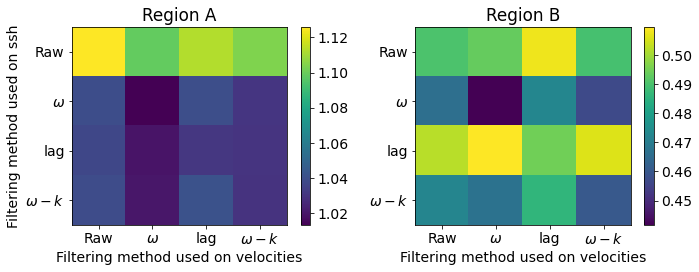

In [134]:
gleckler_list_a = np.array([[etau_au, etau_ao, etau_al, etau_aw],[etae_au, etae_ao, etae_al, etae_aw],
                            [etal_au, etal_ao, etal_al, etal_aw],[etaw_au, etaw_ao, etaw_al, etaw_aw]])

gleckler_list_b = np.array([[etau_bu, etau_bo, etau_bl, etau_bw],[etae_bu, etae_bo, etae_bl, etae_bw],
                           [etal_bu, etal_bo, etal_bl, etal_bw],[etaw_bu, etaw_bo, etaw_bl, etaw_bw]])


plt.figure(figsize=(10,4))
plt.subplot(121)
cs=plt.pcolor(gleckler_list_a)
plt.colorbar(cs)
ax = plt.gca()
ax.invert_yaxis()

ax.set_xticks(np.arange(gleckler_list_a.shape[1])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(gleckler_list_a.shape[0])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']#, '$\omega-k$']
ax.set_yticklabels(labels)
plt.xlabel('Filtering method used on velocities')
plt.ylabel('Filtering method used on ssh')
plt.title('Region A')

plt.subplot(122)
cs = plt.pcolor(gleckler_list_b)
plt.colorbar(cs)
ax = plt.gca()
ax.invert_yaxis()

ax.set_xticks(np.arange(gleckler_list_b.shape[1])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']
ax.set_xticklabels(labels)

ax.set_yticks(np.arange(gleckler_list_b.shape[0])+0.5)
labels = ['Raw', '$\omega$', 'lag', '$\omega-k$']#, '$\omega-k$']
ax.set_yticklabels(labels)
plt.xlabel('Filtering method used on velocities')
#plt.ylabel('Filtering method used on ssh')
plt.title('Region B')

plt.subplots_adjust(wspace=0.3)

plt.tight_layout()

fig=plt.gcf()
fig.savefig('geostrophy_gleckler.png')

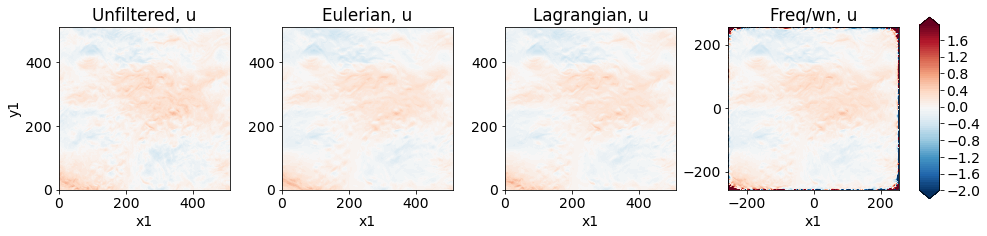

In [53]:
fig=plt.figure(figsize=(14,3.5))

tt=35
plt.subplot(141)
u_unfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.title('Unfiltered, u')

plt.subplot(142)
u_eul_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.ylabel('')
plt.title('Eulerian, u')

plt.subplot(143)
u_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.ylabel('')
plt.title('Lagrangian, u')

plt.subplot(144)
cs = u_wnfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
plt.ylabel('')
plt.title('Freq/wn, u')

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
#fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)

In [415]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4

for tt in range(0,70):
    fig=plt.figure(figsize=(14,3.5))

    plt.subplot(141)
    u_unfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.title('Unfiltered, u')

    plt.subplot(142)
    u_eul_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Eulerian, u')

    plt.subplot(143)
    u_resampled.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Lagrangian, u')

    plt.subplot(144)
    cs = u_wnfilt.isel(time=tt).plot(levels=np.arange(-2,2,0.05),add_colorbar=False)
    plt.ylabel('')
    plt.title('Freq/wn, u')

    plt.tight_layout()

    fig.subplots_adjust(right=0.9,wspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
    fig.colorbar(cs, cax=cbar_ax,extend='both')
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)
    plt.close(fig) 

In [26]:
div_unfilt = (tangrid.interp(tangrid.diff(u_unfilt,'X'),'X')+tangrid.interp(tangrid.diff(v_unfilt,'Y'),'Y'))/1000
div_eulfilt = (tangrid.interp(tangrid.diff(u_eul_resampled,'X'),'X')+tangrid.interp(tangrid.diff(v_eul_resampled,'Y'),'Y'))/1000
div_filt = (tangrid.interp(tangrid.diff(u_resampled,'X'),'X')+tangrid.interp(tangrid.diff(v_resampled,'Y'),'Y'))/1000
div_wnfilt = (tangrid.interp(tangrid.diff(u_wnfilt,'X'),'X').drop_vars(['x1','y1'])+tangrid.interp(tangrid.diff(v_wnfilt,'Y'),'Y').drop_vars(['x1','y1']))/1000


In [134]:
for tt in range(0,70):
    fig=plt.figure(figsize=(14,7))

    plt.subplot(231)
    div_unfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.title('Unfiltered, divergence')

    plt.subplot(232)
    div_eulfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Eulerian, divergence')

    plt.subplot(233)
    div_filt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Lagrangian, divergence')

    plt.subplot(234)
    div_wnfilt.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-5*5,add_colorbar=False)
    plt.ylabel('')
    plt.title('Freq/wn, divergence')
    
    plt.subplot(235)
    cs = fronto_resampled.isel(time=tt).plot(levels=np.arange(-1,1,0.05)*10**-13,add_colorbar=False)
    plt.ylabel('')
    plt.title('Frontogenesis function')

    plt.tight_layout()

    fig.subplots_adjust(right=0.9,wspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
    fig.colorbar(cs, cax=cbar_ax,extend='both')
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt),dpi=200)
    plt.close(fig) 

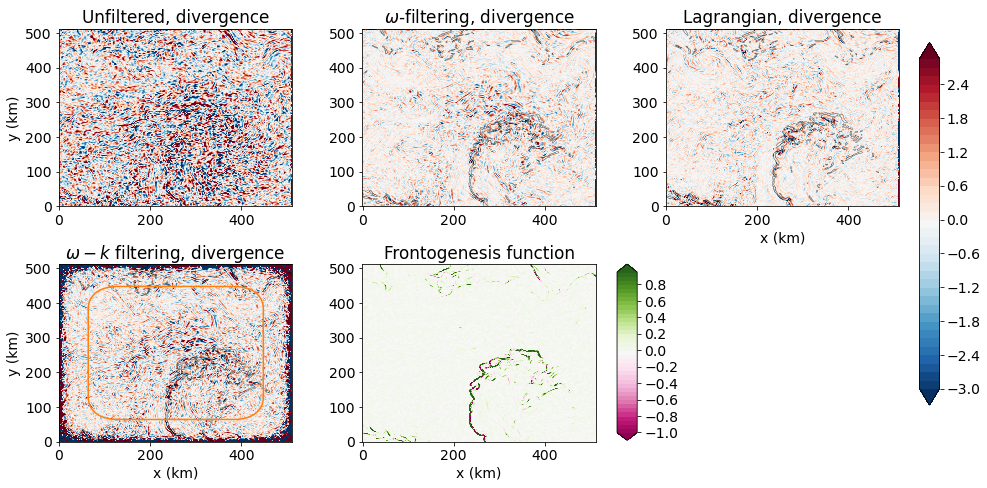

In [35]:
tt=35
fig=plt.figure(figsize=(14,7))

plt.subplot(231)
(div_unfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
plt.title('Unfiltered, divergence')
plt.ylabel('y (km)')
plt.xlabel('')

plt.subplot(232)
(div_eulfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-10, 0.2],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.xlabel('')
plt.title('$\omega$-filtering, divergence')

plt.subplot(233)
(div_filt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-10, 0.2],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.title('Lagrangian, divergence')
plt.ylabel('')
plt.xlabel('x (km)')

plt.subplot(234)
cs=(div_wnfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-10, 0.2],add_colorbar=False,colors='k',linewidths=0.3)

windows.isel(time=1000).plot.contour(levels=[-10,0.5],colors='tab:orange')
plt.ylabel('')
plt.title('$\omega-k$ filtering, divergence')
plt.ylabel('y (km)')
plt.xlabel('x (km)')

    
plt.subplot(235)
cs2 = (fronto_resampled*10**14).isel(time=tt).plot(levels=np.arange(-1,1,0.05),add_colorbar=False,cmap='PiYG',rasterized=True)
plt.ylabel('')
plt.xlabel('x (km)')
plt.title('Frontogenesis function')

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')

cbar_ax = fig.add_axes([0.62, 0.11, 0.02, 0.35])
fig.colorbar(cs2, cax=cbar_ax,extend='both')
fig.savefig("divergence_region_A.png",dpi=200)

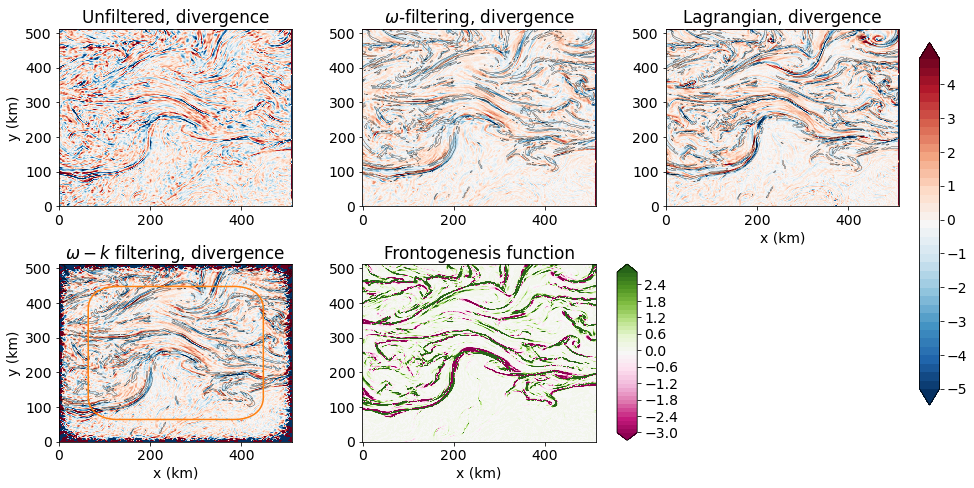

In [27]:
tt=35
fig=plt.figure(figsize=(14,7))

plt.subplot(231)
(div_unfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
plt.title('Unfiltered, divergence')
plt.ylabel('y (km)')
plt.xlabel('')

plt.subplot(232)
(div_eulfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-100, 1],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.xlabel('')
plt.title('$\omega$-filtering, divergence')

plt.subplot(233)
(div_filt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-100, 1],add_colorbar=False,colors='k',linewidths=0.3)
plt.ylabel('')
plt.title('Lagrangian, divergence')
plt.ylabel('')
plt.xlabel('x (km)')

plt.subplot(234)
cs=(div_wnfilt*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
(fronto_resampled*10**14).isel(time=tt).plot.contour(
    levels=[-100, 1],add_colorbar=False,colors='k',linewidths=0.3)
windows.isel(time=1000).plot.contour(levels=[-10,0.5],colors='tab:orange')
plt.ylabel('')
plt.title('$\omega-k$ filtering, divergence')
plt.ylabel('y (km)')
plt.xlabel('x (km)')
    
plt.subplot(235)
cs2 = (fronto_resampled*10**14).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,cmap='PiYG',rasterized=True)
plt.ylabel('')
plt.xlabel('x (km)')
plt.title('Frontogenesis function')

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')

cbar_ax = fig.add_axes([0.62, 0.11, 0.02, 0.35])
fig.colorbar(cs2, cax=cbar_ax,extend='both')
fig.savefig("divergence_region_B.png",dpi=200)